# Face Detection Using dlib's facial Landmark detector and comparing standard algorithms for Emotion Recognition​

In [13]:
# import required modules
import numpy as np
import math
import cv2
import dlib
import time

# set up some required Objects
cap = cv2.VideoCapture(0) #webcam object
detector = dlib.get_frontal_face_detector() # face detector

# Landmark predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

while True:
    
    ret, frame = cap.read()
    
    if not cap.isOpened():
        cap.open()
        
    if not ret:
        break
        
    # waiting for input key from the user
    k = cv2.waitKey(1)

    if k % 256 == 27:   # ESC pressed
        break
    else:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_image = clahe.apply(gray)

        detections = detector(clahe_image, 1) # detect the faces in the image
        for k,d in enumerate(detections): # For each face detected
            shape = predictor(clahe_image, d)
            for i in range(1,68): # there are 68 landmark points for each face detected
                # For each point, draw a red circle with thickness 2 on the original frame
                cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0, 0, 255), 2)

        cv2.imshow("image",frame) #display the frame

#when everything is done, release the capture
cap.release()
cv2.destroyAllWindows()

Facial Landmarks are used to localize and represent salient regions of the face such as,
1. Eyes.
2. Eyebrows.
3. Nose.
4. Mouth.
5. Jawline.

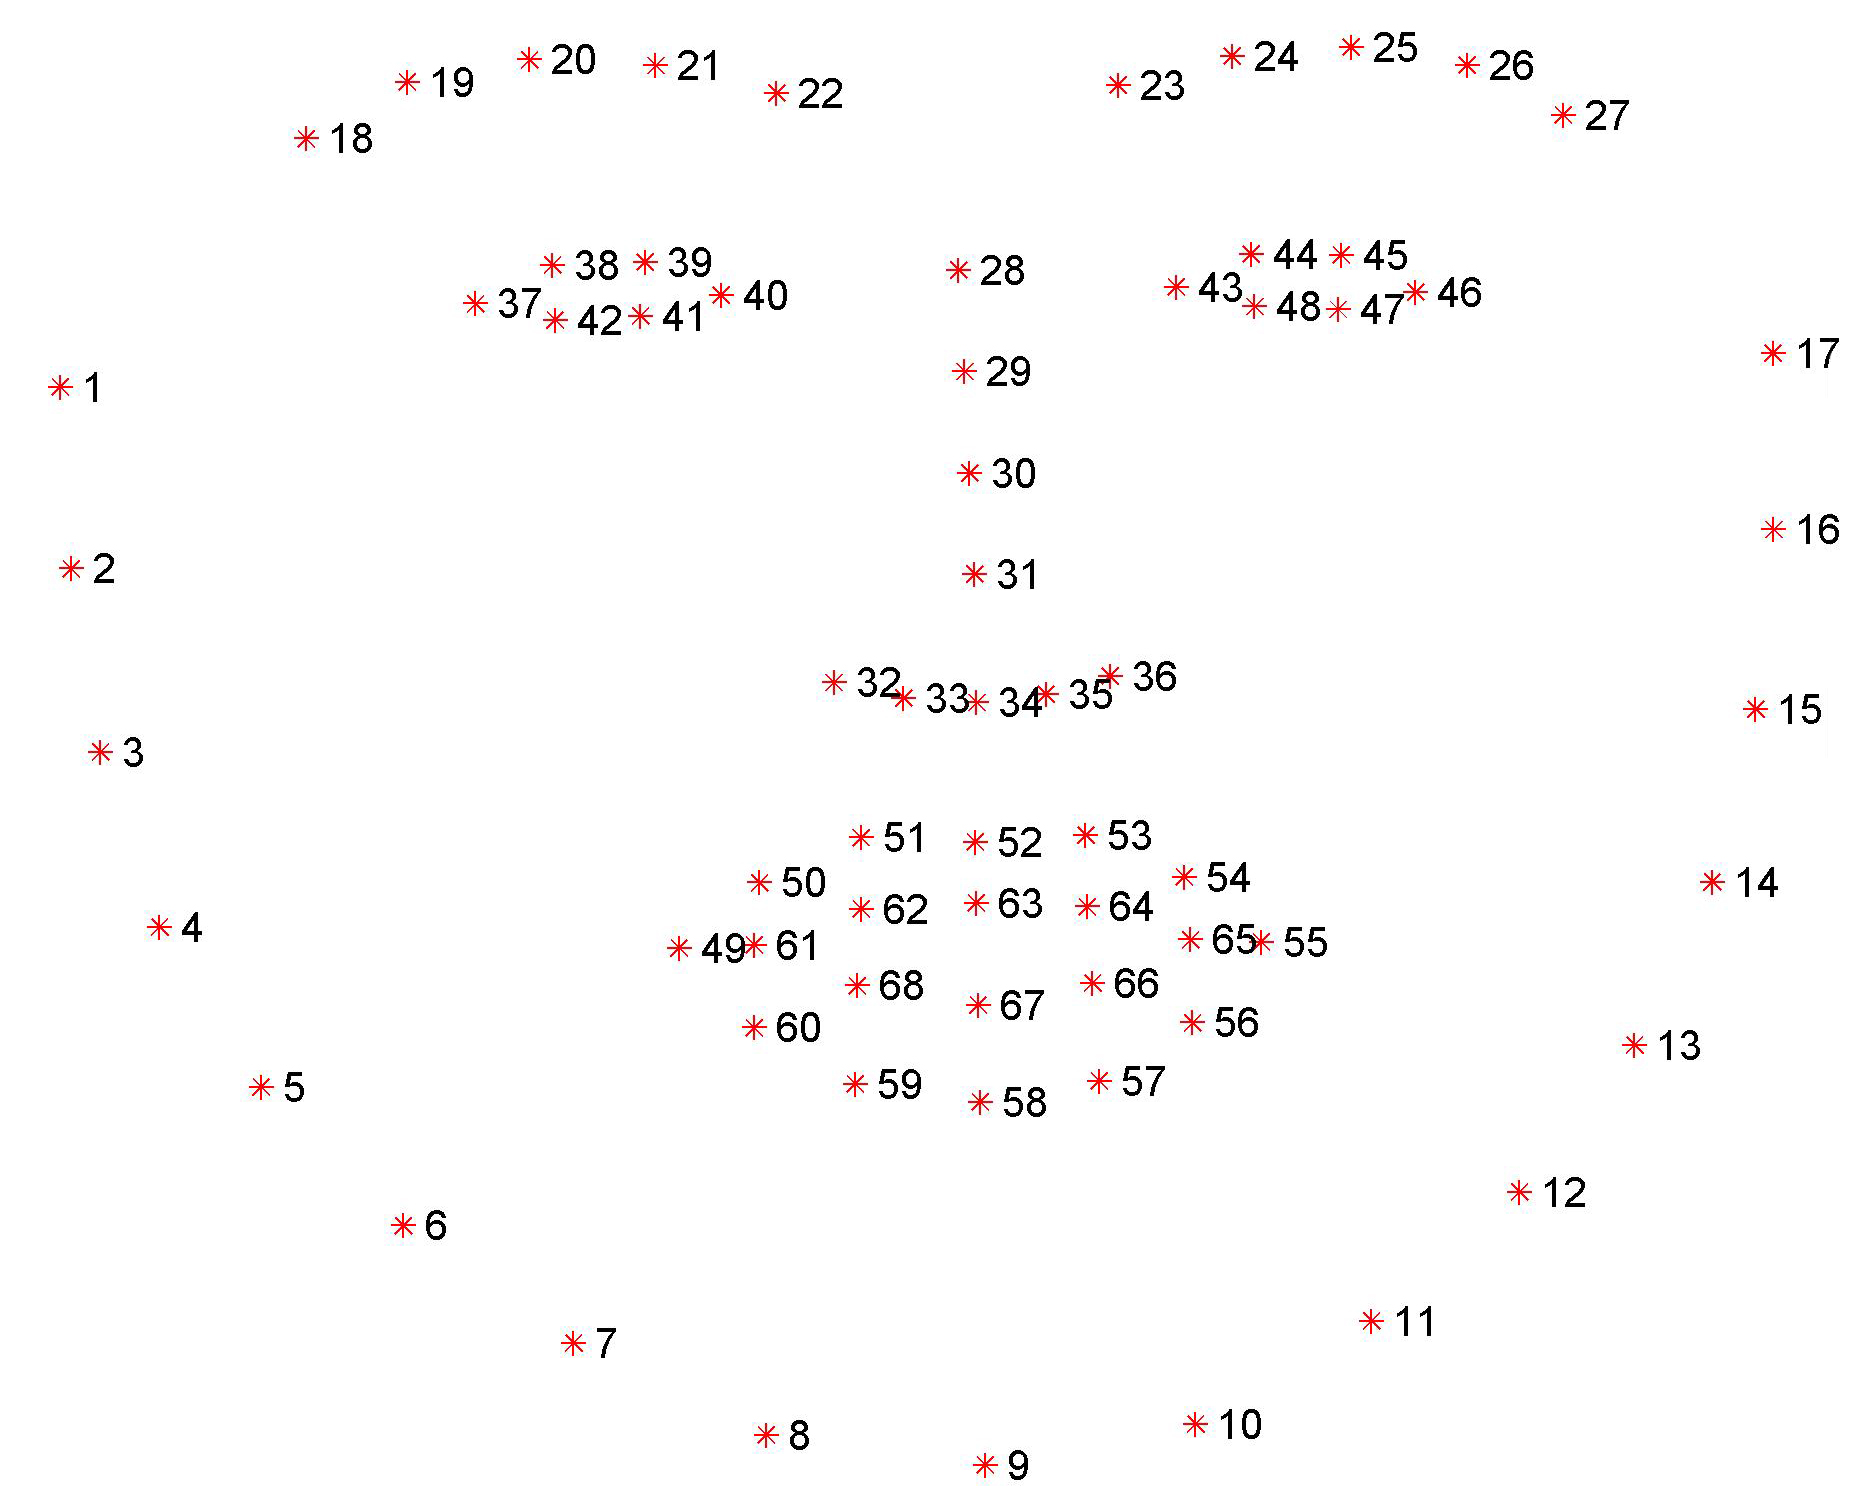

In [40]:
from IPython.display import Image
Image(filename='facial_landmarks_68markup.jpg', width = 600, height = 300)

copyrights: https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/

Above function gives us the facial features required, but it's important to note that what if the face is tilted. So it's better to normalize the above method to get vectorized lanmarks.

In [41]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): # For all detected faces individually
        shape = predictor(image, d) # Draw facial landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): # store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))

        xmean = np.mean(xlist) # find both coordinates of center of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] # Calculate the distance center <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorized = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist): # Store all landmarks in one list in the form of x1, y1, x2, y2 etc.
            landmarks_vectorized.append(w)
            landmarks_vectorized.append(z)
            meannp = np.asarray((ymean, xmean))
            coornp = np.asarray((z, w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorized.append(dist)
            landmarks_vectorized.append(((math.atan2(y, x)*360))/(2*math.pi))

        data = {}

        data['landmarks_vectorized'] = landmarks_vectorized

    if len(detections) < 0 :
        data['landmarks_vectorized'] = landmarks_vectorized
        
    #print(data)

It's time to process the dataset to label particular emotions and store it in separate folder.

In [42]:
import glob
from shutil import copyfile

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #define emotion order
participants = glob.glob("source_emotion\\*") # returns a list of all folders with participant numbers

#print(participants)
for x in participants:
    part = "%s" %x[-4:] # store current participation number
    for sessions in glob.glob("%s\\*" %x): # Store list of sessions for current participant
        for files in glob.glob("%s\\*" %sessions):
            current_session = files[20:-30]
            file = open(files, 'r')
            
            emotion = int(float(file.readline())) # emotions are encoded as a float, read as a float and then convert it to integer
            
            sourcefile_emotion = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[-1] # get path for last image in sequence, which contains the emotion
            sourcefile_neutral = glob.glob("source_images\\%s\\%s\\*" %(part, current_session))[0]
            
            dest_neutral = "sorted_set\\neutral\\%s" %sourcefile_neutral[25:] # get path to put neutral image
            dest_emotion = "sorted_set\\%s\\%s" %(emotions[emotion], sourcefile_emotion[25:]) # Do same for emotion containing image
            
            copyfile(sourcefile_neutral, dest_neutral) # Copy_file
            copyfile(sourcefile_emotion, dest_emotion) # Copy_file

Algorithms work better if we extract just the face and keep it in separate folder. Let's call it dataset folder.
Using Open CV's Haar classifiers' to extract face from a picture.

In [43]:
import cv2
import glob

faceDet = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
faceDet_two = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
faceDet_three = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
faceDet_four = cv2.CascadeClassifier("haarcascade_frontalface_alt_tree.xml")

emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #define emotions

def detect_faces(emotion):
    files = glob.glob("sorted_set\\%s\\*" %emotion) #Get a list of all images with emotion
    
    filenumber = 0
    for f in files:
        frame = cv2.imread(f) #Open image
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert image to grayscale

        # Detect face using 4 different classifiers
        face = faceDet.detectMultiScale(gray, scaleFactor= 1.1, minNeighbors= 10, minSize= (5,5), flags= cv2.CASCADE_SCALE_IMAGE)
        face_two = faceDet_two.detectMultiScale(gray, scaleFactor= 1.1, minNeighbors= 10, minSize= (5,5), flags= cv2.CASCADE_SCALE_IMAGE)
        face_three = faceDet_three.detectMultiScale(gray, scaleFactor= 1.1, minNeighbors= 10, minSize= (5,5), flags= cv2.CASCADE_SCALE_IMAGE)
        face_four = faceDet_four.detectMultiScale(gray, scaleFactor= 1.1, minNeighbors= 10, minSize= (5,5), flags= cv2.CASCADE_SCALE_IMAGE)

        #Go over detected faces, stop at the first detected face, return empty if no face.
        if len(face) == 1:
            facefeatures = face
        elif len(face_two) == 1:
            facefeatures = face_two
        elif len(face_three) == 1:
            facefeatures = face_three
        elif len(face_four) == 1:
            facefeatures = face_four
        else:
            facefeatures = ""

        #Cut and save the face
        for (x, y, w, h) in facefeatures: # get coordinates and size of the rectangle containing the face
            print("Face found in file: %s" %f)
            gray = gray[y:y+h, x:x+w] # cut the frame to size

        try:
            out = cv2.resize(gray, (350,350)) # Resize face so all images have same size
            cv2.imwrite("dataset\\%s\\%s.jpg" %(emotion, filenumber), out) # write image
        except:
            pass # if error pass file
        filenumber+= 1 # increment image number

for emotion in emotions:
    detect_faces(emotion)

Face found in file: sorted_set\neutral\00_002_00000001.png
Face found in file: sorted_set\neutral\00_005_00000001.png
Face found in file: sorted_set\neutral\00_006_00000001.png
Face found in file: sorted_set\neutral\01_001_00000001.png
Face found in file: sorted_set\neutral\01_002_00000001.png
Face found in file: sorted_set\neutral\01_004_00000001.png
Face found in file: sorted_set\neutral\01_006_00000001.png
Face found in file: sorted_set\neutral\02_001_00000001.png
Face found in file: sorted_set\neutral\02_002_00000001.png
Face found in file: sorted_set\neutral\02_003_00000001.png
Face found in file: sorted_set\neutral\02_004_00000001.png
Face found in file: sorted_set\neutral\02_009_00000001.png
Face found in file: sorted_set\neutral\03_001_00000001.png
Face found in file: sorted_set\neutral\03_002_00000001.png
Face found in file: sorted_set\neutral\03_006_00000001.png
Face found in file: sorted_set\neutral\04_001_00000001.png
Face found in file: sorted_set\neutral\04_002_00000001.p

Face found in file: sorted_set\neutral\42_001_00000001.png
Face found in file: sorted_set\neutral\42_002_00000001.png
Face found in file: sorted_set\neutral\42_004_00000001.png
Face found in file: sorted_set\neutral\42_006_00000001.png
Face found in file: sorted_set\neutral\44_001_00000001.png
Face found in file: sorted_set\neutral\44_003_00000001.png
Face found in file: sorted_set\neutral\44_006_00000001.png
Face found in file: sorted_set\neutral\45_004_00000001.png
Face found in file: sorted_set\neutral\45_005_00000001.png
Face found in file: sorted_set\neutral\46_001_00000001.png
Face found in file: sorted_set\neutral\46_002_00000001.png
Face found in file: sorted_set\neutral\46_003_00000001.png
Face found in file: sorted_set\neutral\46_004_00000001.png
Face found in file: sorted_set\neutral\47_002_00000001.png
Face found in file: sorted_set\neutral\48_002_00000001.png
Face found in file: sorted_set\neutral\49_002_00000001.png
Face found in file: sorted_set\neutral\50_001_00000001.p

Face found in file: sorted_set\neutral\89_002_00000001.png
Face found in file: sorted_set\neutral\89_003_00000001.png
Face found in file: sorted_set\neutral\90_002_00000001.png
Face found in file: sorted_set\neutral\90_006_00000001.png
Face found in file: sorted_set\neutral\90_007_00000001.png
Face found in file: sorted_set\neutral\91_001_00000001.png
Face found in file: sorted_set\neutral\91_003_00000001.png
Face found in file: sorted_set\neutral\92_001_00000001.png
Face found in file: sorted_set\neutral\92_003_00000001.png
Face found in file: sorted_set\neutral\92_004_00000001.png
Face found in file: sorted_set\neutral\93_001_00000001.png
Face found in file: sorted_set\neutral\93_004_00000001.png
Face found in file: sorted_set\neutral\94_001_00000001.png
Face found in file: sorted_set\neutral\94_004_00000001.png
Face found in file: sorted_set\neutral\95_001_00000001.png
Face found in file: sorted_set\neutral\95_002_00000001.png
Face found in file: sorted_set\neutral\95_006_00000001.p

Face found in file: sorted_set\disgust\81_008_00000011.png
Face found in file: sorted_set\disgust\82_007_00000010.png
Face found in file: sorted_set\disgust\85_004_00000017.png
Face found in file: sorted_set\disgust\87_004_00000012.png
Face found in file: sorted_set\disgust\88_004_00000020.png
Face found in file: sorted_set\disgust\90_006_00000011.png
Face found in file: sorted_set\disgust\95_006_00000013.png
Face found in file: sorted_set\disgust\96_003_00000012.png
Face found in file: sorted_set\disgust\97_004_00000030.png
Face found in file: sorted_set\disgust\98_003_00000013.png
Face found in file: sorted_set\disgust\99_007_00000012.png
Face found in file: sorted_set\fear\01_004_00000056.png
Face found in file: sorted_set\fear\02_003_00000016.png
Face found in file: sorted_set\fear\02_004_00000052.png
Face found in file: sorted_set\fear\04_004_00000015.png
Face found in file: sorted_set\fear\06_004_00000038.png
Face found in file: sorted_set\fear\11_003_00000014.png
Face found in f

Face found in file: sorted_set\surprise\14_001_00000029.png
Face found in file: sorted_set\surprise\15_001_00000008.png
Face found in file: sorted_set\surprise\16_001_00000014.png
Face found in file: sorted_set\surprise\17_001_00000014.png
Face found in file: sorted_set\surprise\19_001_00000011.png
Face found in file: sorted_set\surprise\22_001_00000012.png
Face found in file: sorted_set\surprise\22_001_00000030.png
Face found in file: sorted_set\surprise\24_001_00000014.png
Face found in file: sorted_set\surprise\25_007_00000009.png
Face found in file: sorted_set\surprise\26_001_00000015.png
Face found in file: sorted_set\surprise\26_004_00000012.png
Face found in file: sorted_set\surprise\27_001_00000017.png
Face found in file: sorted_set\surprise\29_002_00000011.png
Face found in file: sorted_set\surprise\30_001_00000018.png
Face found in file: sorted_set\surprise\31_001_00000016.png
Face found in file: sorted_set\surprise\32_001_00000022.png
Face found in file: sorted_set\surprise\

In [8]:
import cv2
import glob
import random
import numpy as np

#emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
emotions = ["anger", "disgust", "happiness", "neutral", "surprise"]
fishface = cv2.face.FisherFaceRecognizer_create() # Initialize fisher face classifier
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

data = {}

def get_files(emotion): # Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] # get first 80% of the list
    prediction = files[-int(len(files)*0.2):] # get last 20% of the list
    return training, prediction

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        # Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) # open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
            clahe_image = clahe.apply(gray)
            training_data.append(clahe_image) # append image array to training data list
            training_labels.append(emotions.index(emotion))
            
        for item in prediction: # Repeat above process for prediction set
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            prediction_data.append(clahe_image) # append image array to training data list
            prediction_labels.append(emotions.index(emotion))
            
    return training_data, training_labels, prediction_data, prediction_labels
    
def run_recognizer():
    training_data, training_labels, prediction_data, prediction_labels = make_sets()
    
    print("training fisher face classifier")
    print("size of the training set is:", len(training_labels), "images")
    fishface.train(training_data, np.asarray(training_labels))
    
    print("predicting classification set")
    cnt = 0
    correct = 0
    incorrect = 0
    for image in prediction_data:
        pred, conf = fishface.predict(image)
        if pred == prediction_labels[cnt]:
            correct += 1
            cnt += 1
        else:
            cv2.imwrite("dataset\\difficult\\%s_%s_%s.jpg" %(emotions[prediction_labels[cnt]], emotions[pred], cnt), image)
            
            incorrect += 1
            cnt += 1
    return ((100*correct)/(correct + incorrect))
        
metascore = []
for i in range(0,10):
    correct = run_recognizer()
    print("got", correct, "percent correct!")
    metascore.append(correct)
    
print ("\n\nend score:", np.mean(metascore), "percent correct!")      

training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 91.75257731958763 percent correct!
training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 89.69072164948453 percent correct!
training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 88.65979381443299 percent correct!
training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 91.75257731958763 percent correct!
training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 91.75257731958763 percent correct!
training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 91.75257731958763 percent correct!
training fisher face classifier
size of the training set is: 395 images
predicting classification set
got 86.5979381443299 percent correct!
training fishe

In [11]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

#emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
emotions = ["anger", "disgust", "happiness", "neutral", "surprise"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
clf = SVC(kernel='linear', probability=True, tol=1e-5, verbose = False) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
    
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels

accur_lin = []
for i in range(0, 10):
    print("Making sets %s" %i) # make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()
    
    npar_train = np.array(training_data) # Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("Training SVM linear %s" %i) # training SVM
    clf.fit(npar_train, training_labels)
    
    print("Getting accuracies %s" %i) # Use score function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print("linear: ", pred_lin)
    accur_lin.append(pred_lin) # Store accuracy in a list
    
print("Mean value linear SVM: %s" %np.mean(accur_lin)) # Get mean accuracy of the 10 runs

Making sets 0
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM linear 0
Getting accuracies 0
linear:  0.9278350515463918
Making sets 1
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM linear 1
Getting accuracies 1
linear:  0.9072164948453608
Making sets 2
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM linear 2
Getting accuracies 2
linear:  0.9278350515463918
Making sets 3
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM linear 3
Getting accuracies 3
linear:  0.9278350515463918
Making sets 4
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM linear 4
Getting accuracies 4
linear:  0.9278350515463918
Making sets 5
 working on anger
 working on disgust
 working on happin

In [10]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

#emotions = ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"] #Emotion list
emotions = ["anger", "disgust", "happiness", "neutral", "surprise"] #Emotion list
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
cpf = SVC(kernel='poly', probability=True, tol=1e-5, verbose = False) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset\\%s\\*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
    
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels

accur_poly = []
for i in range(0, 10):
    print("Making sets %s" %i) # make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()
    
    npar_train = np.array(training_data) # Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("Training SVM polynomial %s" %i) # training SVM
    cpf.fit(npar_train, npar_trainlabs)
    
    print("Getting accuracies %s" %i) # Use score function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_poly = cpf.score(npar_pred, prediction_labels)
    print("linear: ", pred_poly)
    accur_poly.append(pred_poly) # Store accuracy in a list
    
print("Mean value Polynomial SVM: %s" %np.mean(accur_poly)) # Get mean accuracy of the 10 runs

Making sets 0
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM polynomial 0
Getting accuracies 0
linear:  0.7628865979381443
Making sets 1
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM polynomial 1
Getting accuracies 1
linear:  0.8144329896907216
Making sets 2
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM polynomial 2
Getting accuracies 2
linear:  0.8041237113402062
Making sets 3
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM polynomial 3
Getting accuracies 3
linear:  0.8041237113402062
Making sets 4
 working on anger
 working on disgust
 working on happiness
 working on neutral
 working on surprise
Training SVM polynomial 4
Getting accuracies 4
linear:  0.8041237113402062
Making sets 5
 working on anger
 working on disgus

# Conclusion:

Dlib's face detector model "shape_predictor_68_face_landmarks.dat"  uses HOG (Histogram of Oriented Gradients) + Linear SVM method for face detection.

Dataset has very few images for emotions like ["contempt", "fear", "sadness"], so reduced dataset to check accuracy of these different algorithms for emotion recognition.

From the outputs we got above we found the accuracies of these classification algorithms are:

After reducing dataset: (395 images)
                                Fisher Face classifier: 90.41%
         Linear SVM (with 68 landmark predictor model): 91.95%
     Polynomial SVM (with 68 landmark predictor model): 79.58%
    
Before reducing dataset: (451 images)
                                Fisher face classifier: 82.63%
        Linear SVM (with 68 landmark predictor model) : 83.09%
    Polynomial SVM (with 68 landmark predictor model) : 70%


Future scope: Have to implement a model using neural network, and compare the accuracy with these algorithms.